# Predict Heart Disease with Machine Learning <a id='top'></a>
Welcome to this notebook! This notebook will build a classification model that can predict whether a person have heart disease or not given their medical status.

**Note:** The dataset used to build this model is collected from [this Kaggle dataset](https://www.kaggle.com/cherngs/heart-disease-cleveland-uci). This data has been re-processed, and contains 14 columns (including the predicted target). 

The discriptions of each column are as follows:
1. age: age in years
2. sex (1 = male; 0 = female)
3. cp - chest pain type (4 values)
    * Value 0: typical angina
    * Value 1: atypical angina
    * Value 2: non-anginal pain
    * Value 3: asymptomatic
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol - serum cholestoral in mg/dl
6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
7. restecg - resting electrocardiographic results (values 0,1,2)
    * Value 0: normal
    * Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    * Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest
11. slope - the slope of the peak exercise ST segment
    * Value 0: upsloping
    * Value 1: flat
    * Value 2: downsloping
12. ca - number of major vessels (0-3) colored by flourosopy
13. thal - 0 = normal; 1 = fixed defect; 2 = reversable defectage
14. target - have heart disease or not (1 = no, 0 = yes)

**Table of contents:**
* [Data exploration](#data-exploration)
* [Data visualization](#visualization)
* [Preprocessing data for modelling](#preprocess-data)
* [Modelling](#modelling)
* [Tuning KNN classifier](#tuning-knn)
* [Tuning logistic regression](#tuning-log-reg)
* [Tuning random forest classifier](#tuning-rfclassifier)
* [Save the model](#save-model)
* [Predict a single patient](#predict-single)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

import joblib

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report


In [2]:
plt.style.use('seaborn-darkgrid')
sns.set_style('darkgrid')
pio.renderers.default = 'notebook_connected'

In [3]:
df_heart_disease = pd.read_csv('./data/heart_disease_correct_cleveland.csv')
df_heart_disease.shape

(297, 14)

## Data exploration <a id='data-exploration'></a>
[Back to top](#top)

What the questions about the data do we want to answer?
* What are the data types of each columns?
* How to deal with missing values?
* How to deal with outliers?
* The correlation of features?

In [4]:
df_heart_disease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [5]:
df_heart_disease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       297 non-null    int64  
 1   sex       297 non-null    int64  
 2   cp        297 non-null    int64  
 3   trestbps  297 non-null    int64  
 4   chol      297 non-null    int64  
 5   fbs       297 non-null    int64  
 6   restecg   297 non-null    int64  
 7   thalach   297 non-null    int64  
 8   exang     297 non-null    int64  
 9   oldpeak   297 non-null    float64
 10  slope     297 non-null    int64  
 11  ca        297 non-null    int64  
 12  thal      297 non-null    int64  
 13  target    297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


In [6]:
df_heart_disease.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Fortunately for us, all columns are in numeric dtyps and there are no missing values. That's one less step covered.

## Data visualization <a id='visualization'></a>
[Back to top](#top)

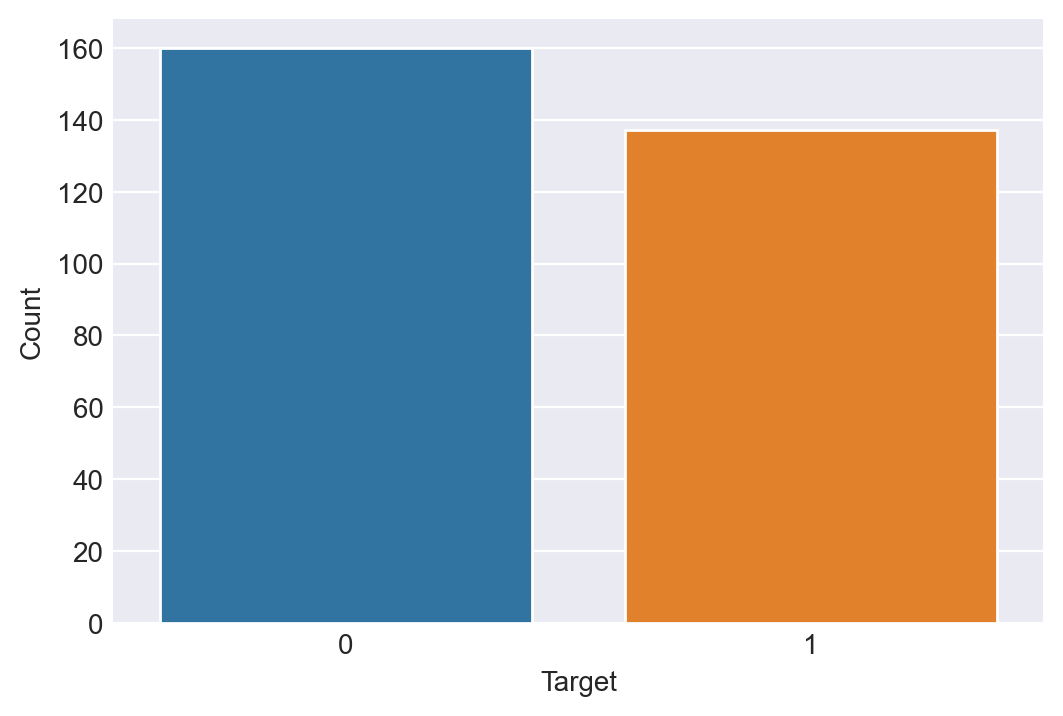

In [7]:
plt.figure(figsize=(6, 4), dpi=200)

sns.countplot(data=df_heart_disease, x='target')

plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

Somewhat balance. But what is the target spread for each gender?

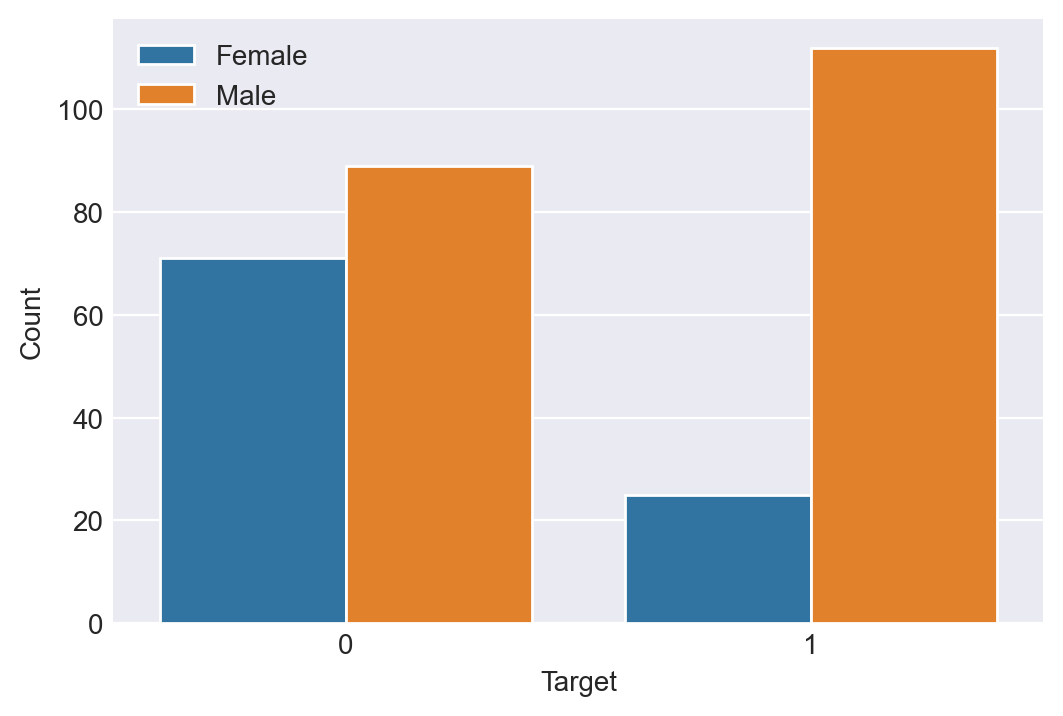

In [8]:
plt.figure(figsize=(6, 4), dpi=200)

sns.countplot(data=df_heart_disease, x='target', hue='sex')

plt.xlabel('Target')
plt.ylabel('Count')
plt.legend(['Female', 'Male'])
plt.show()

What are the age distribution of people who have heart disease?

In [9]:
fig = px.histogram(data_frame=df_heart_disease[df_heart_disease['target'] == 0], x='age',
                   title='Age Distribution of People with Heart Disease',
                   marginal='box',
                   labels={'count': 'Count',
                   'age': 'Age'})

fig.show()


It looks like people from age 50 - 60 are likely to have heart disease.

Now I want to look at the relationship of `chol`, and `trestbps`. Basically, if a person have high serum cholesterol level means that person is likely to have reduced blood flow.

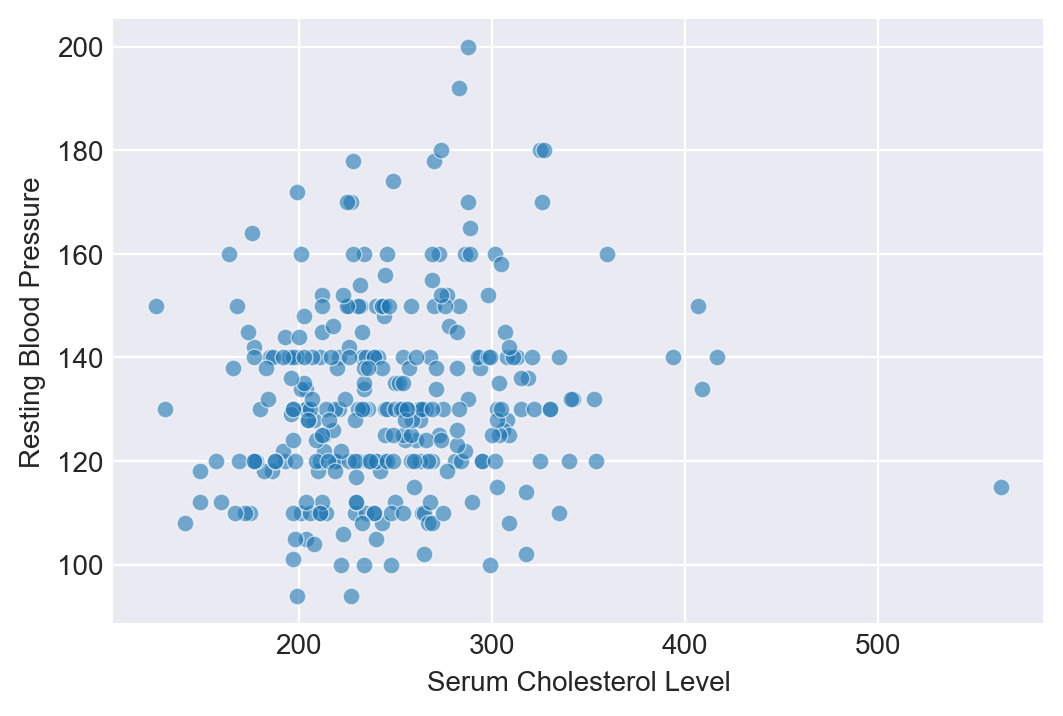

In [10]:
plt.figure(figsize=(6, 4), dpi=200)

sns.scatterplot(data=df_heart_disease, x='chol',
                y='trestbps', alpha=0.6)

plt.xlabel('Serum Cholesterol Level')
plt.ylabel('Resting Blood Pressure')
plt.show()


From what I have collected from the internet, idealy your serum cholesterol level should below 200. High cholesterol level will clog your bloodstream and this will link to high blood pressure. As quoted from the internet:

> Because the arteries are stiff or narrowed — perhaps because of high cholesterol buildup — your heart has to work harder to pump the blood through them.

Blood pressure below 120 mm Hg is considered healthy. This raises a question: in the above scatter plot, there is one person with cholesterol level above 500 but their blood pressure is below 120. Let's take a look!

In [11]:
df_heart_disease.query('chol > 500 and trestbps < 120')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
79,67,0,2,115,564,0,2,160,0,1.6,1,0,2,0


OK so this answers our question. This is a 67-year-old female patient who have heart disease - as expected, despite her resting blood pressure is below 120 mm Hg.

I also want to take a look at other patients whose blood pressure is below 120 mm Hg but serum chol level above 200. Do they all have heart disease as well?

In [12]:
df_heart_disease.query('chol > 200 and trestbps < 120')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
18,45,1,0,110,264,0,0,132,0,1.2,1,0,2,1
43,54,1,1,108,309,0,0,156,0,0.0,0,0,2,0
52,48,1,1,110,229,0,0,168,0,1.0,2,0,2,1
55,46,0,1,105,204,0,0,172,0,0.0,0,0,0,0
66,41,1,1,110,235,0,0,153,0,0.0,0,0,0,0
70,34,0,1,118,210,0,0,192,0,0.7,0,0,0,0
73,71,0,2,110,265,1,2,130,0,0.0,0,1,0,0
78,68,1,2,118,277,0,0,151,0,1.0,0,1,2,0
79,67,0,2,115,564,0,2,160,0,1.6,1,0,2,0


Do they all have heart disease? Some of them do, some of them don't. May be there are other factors that are needed to take into account.

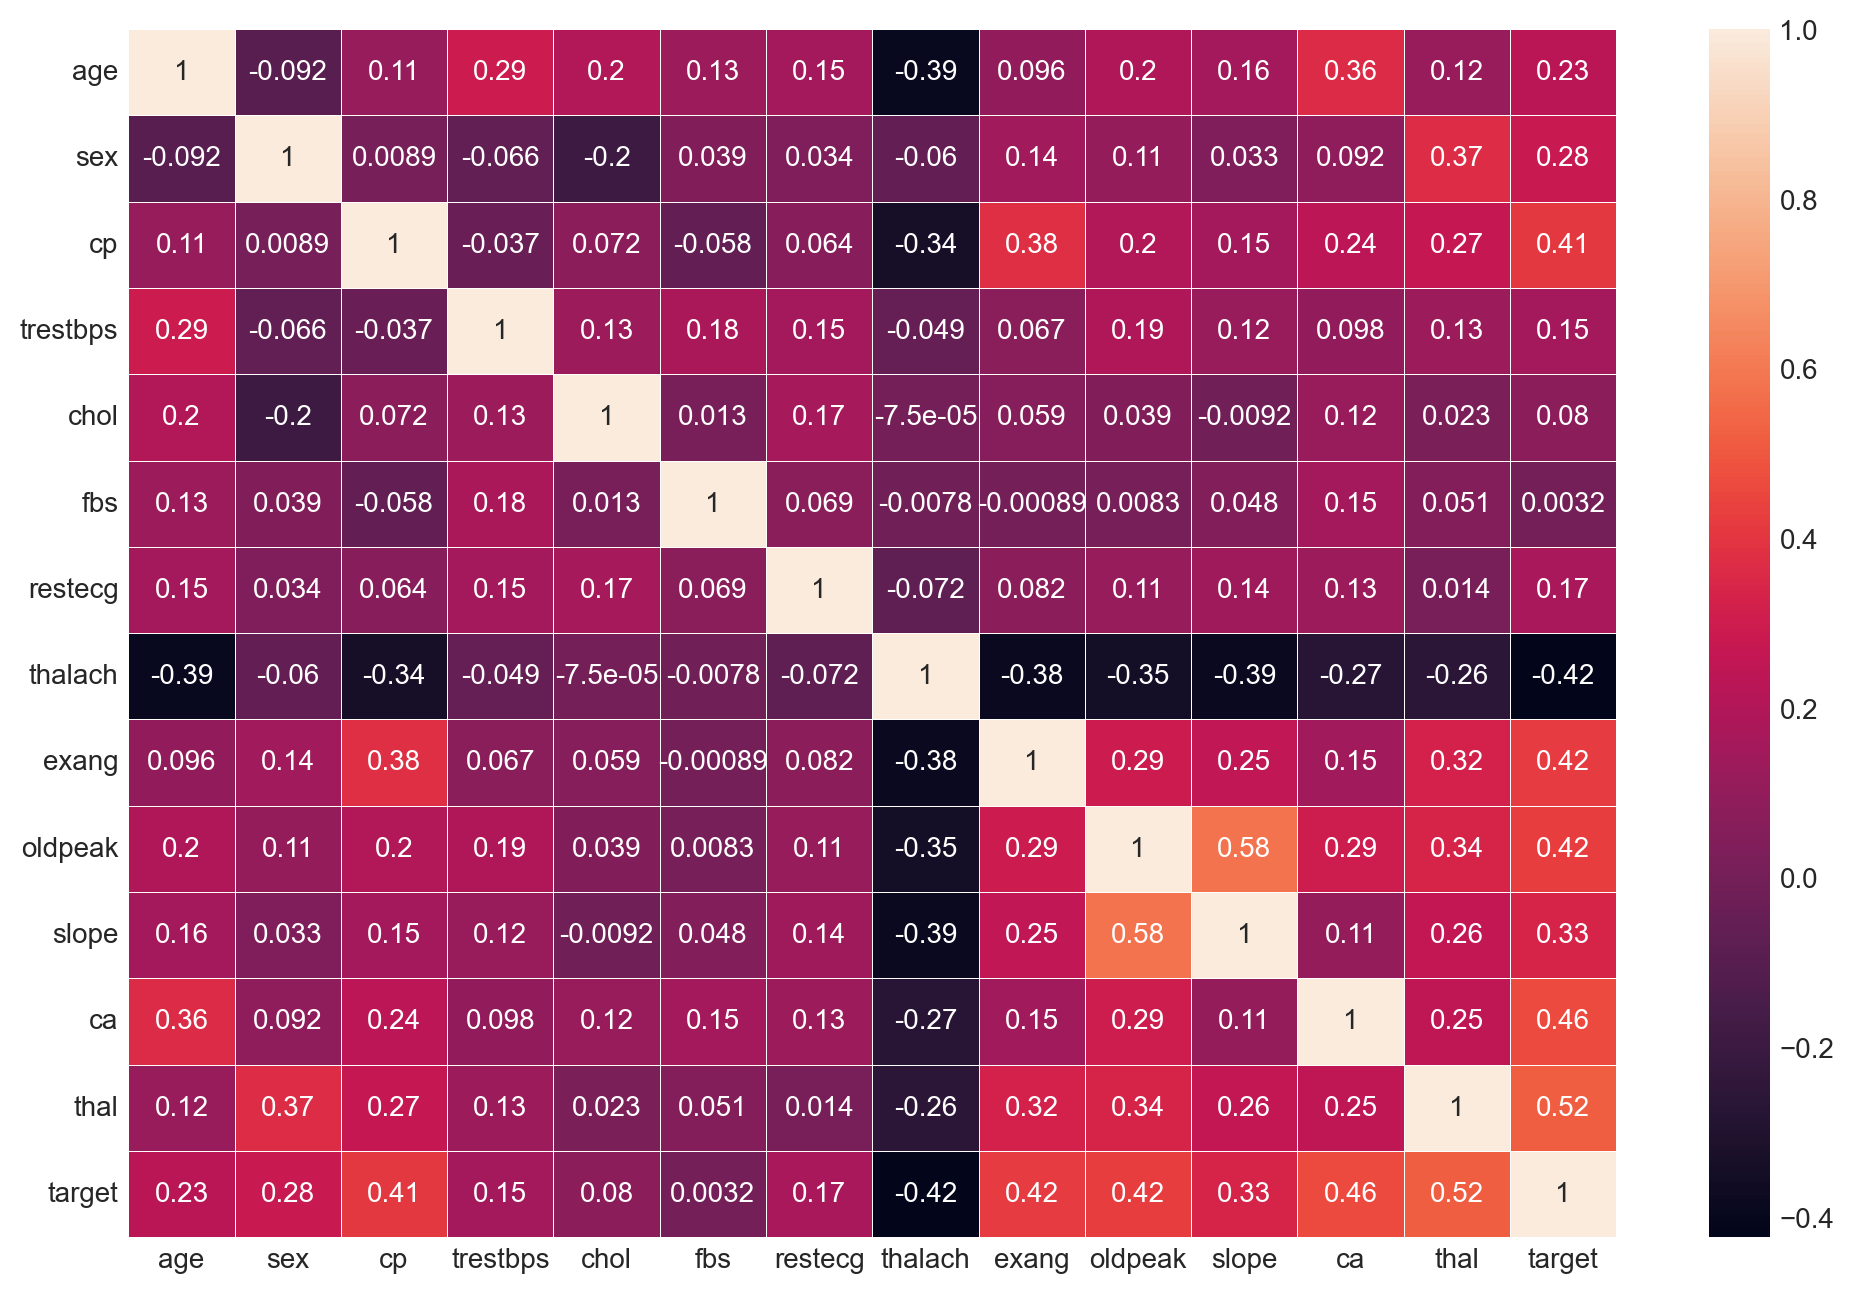

In [13]:
df_heart_disease_corr = df_heart_disease.corr()

plt.figure(figsize=(12, 8), dpi=200)

sns.heatmap(data=df_heart_disease_corr, annot=True, linewidths=0.3)

plt.show()

The heatmap shows us the correlation of between each feature and how they are related to the target variable. The correlation can be negative (increase in values of a feature decreases the value of target variable) or positive (increase in values of a feature increases the value of the target variable).

According to the above heatmap, `cp` and `thalach` affect target variable the most, meanwhile `exang` and `oldpeak` negatively affect the target variable.

Let's plot them all out.

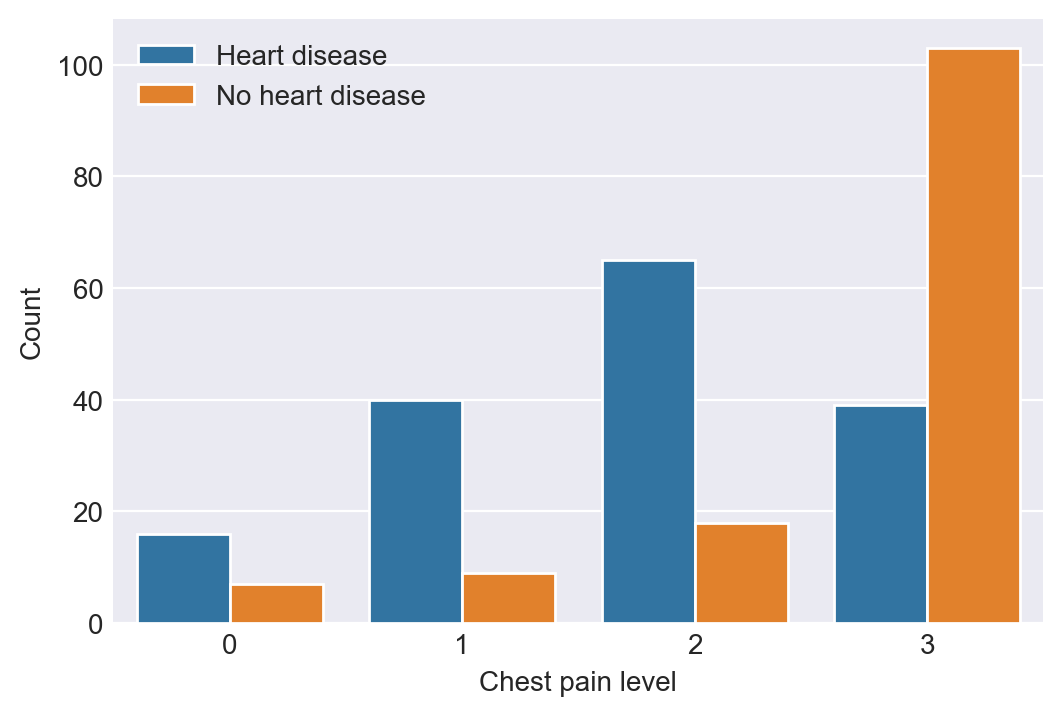

In [14]:
plt.figure(figsize=(6, 4), dpi=200)
sns.countplot(data=df_heart_disease,
              x='cp',
              hue='target')

plt.ylabel('Count')
plt.xlabel('Chest pain level')
plt.legend(['Heart disease', 'No heart disease'])
plt.show()

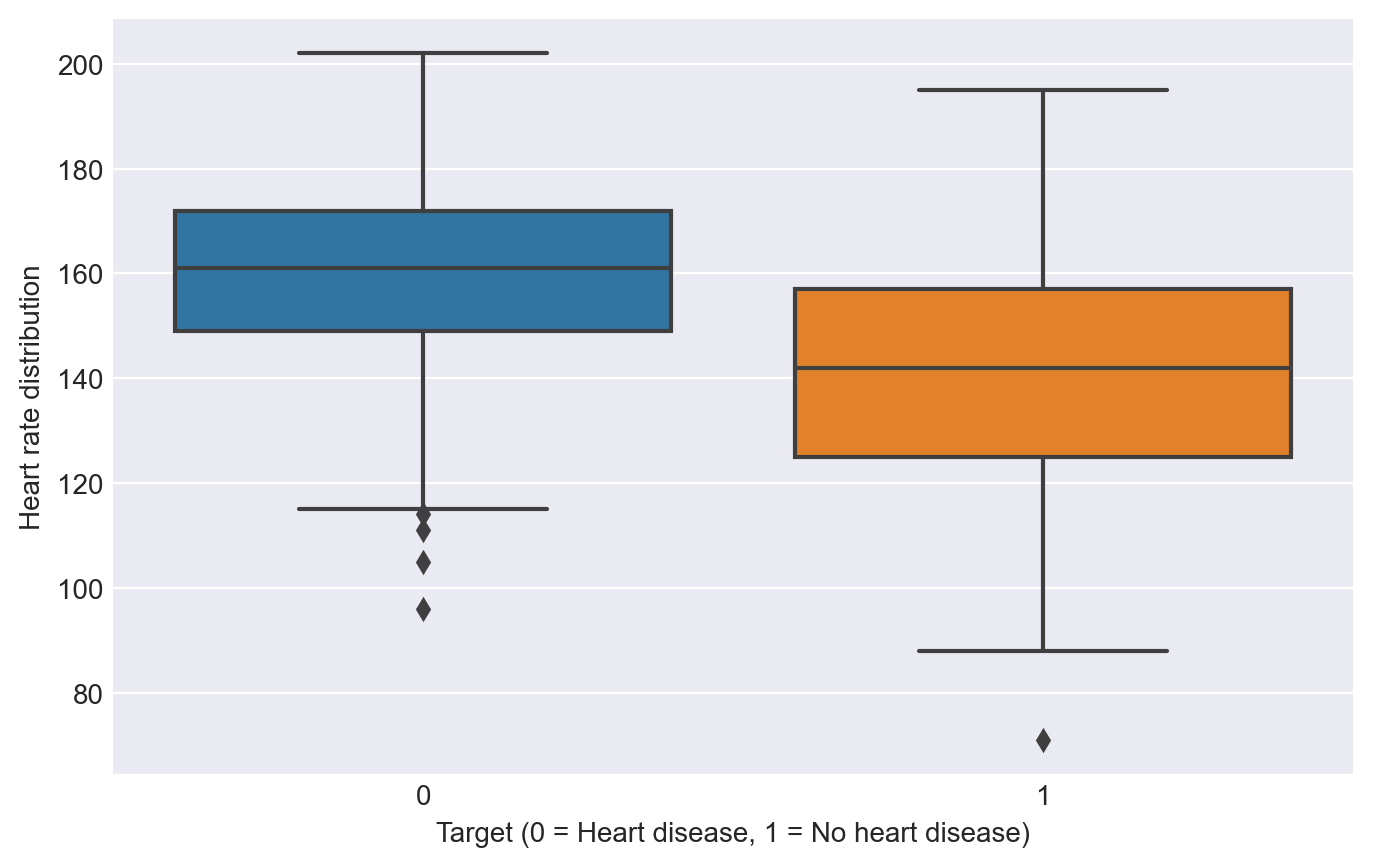

In [15]:
plt.figure(figsize=(8, 5), dpi=200)

sns.boxplot(data=df_heart_disease,
                x='target',
                y='thalach')

plt.ylabel('Heart rate distribution')
plt.xlabel('Target (0 = Heart disease, 1 = No heart disease)')
plt.show()

It looks like people diagnosed with heart disease tend to have higher heart rate.

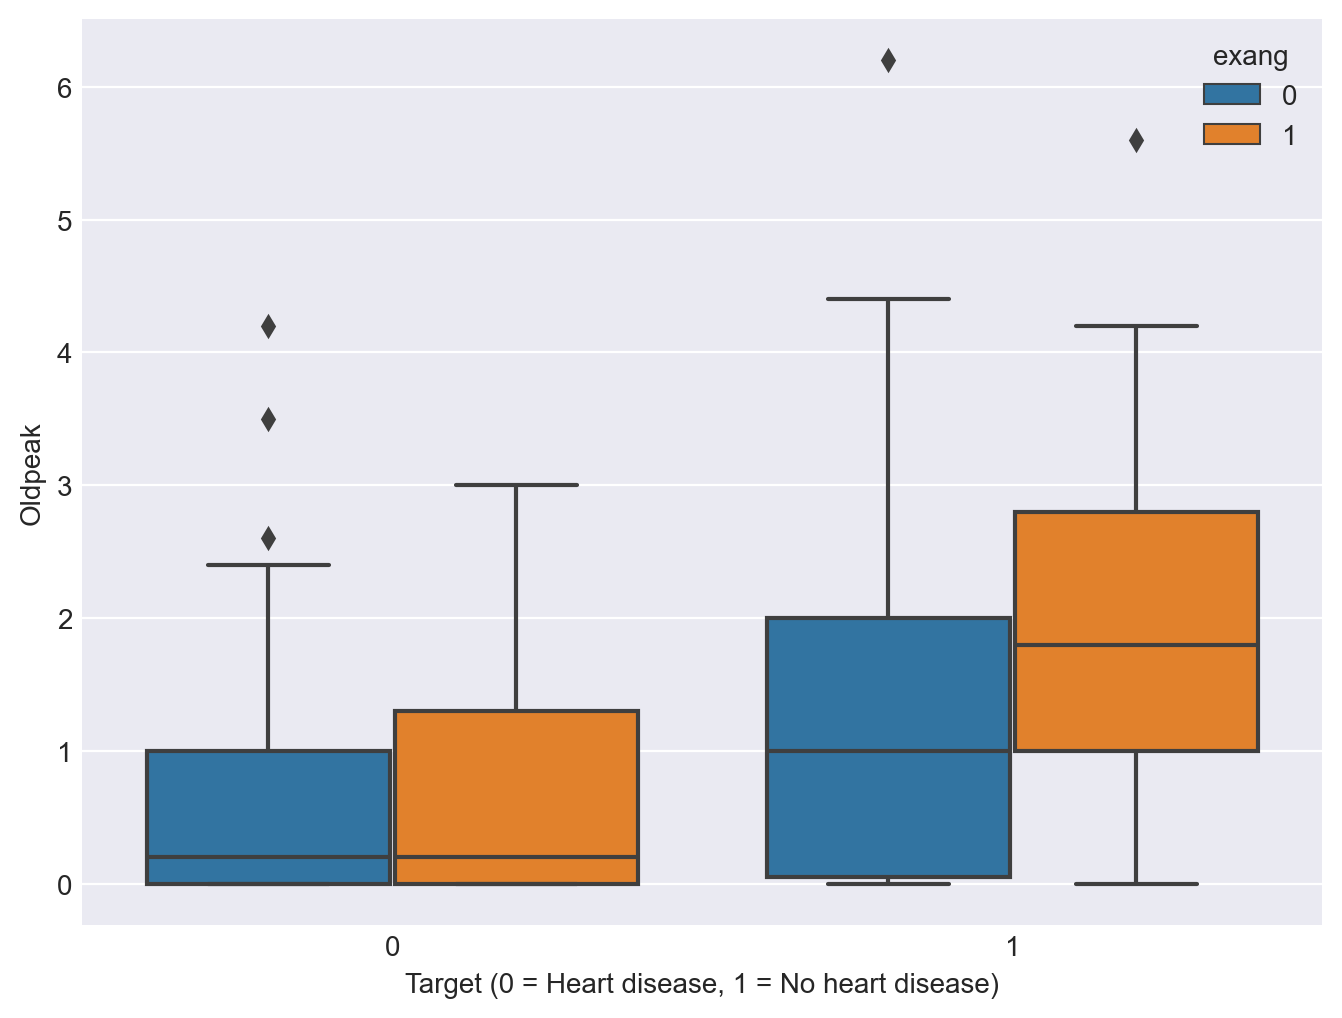

In [16]:
plt.figure(figsize=(8, 6), dpi=200)
sns.boxplot(data=df_heart_disease, x='target', y='oldpeak', hue='exang')

plt.ylabel('Oldpeak')
plt.xlabel('Target (0 = Heart disease, 1 = No heart disease)')
plt.show()

## Preprocessing Data <a id='preprocess-data'></a>
[Back to top](#top)

Now that we have an overview of our data. Let's prepare our data for fitting a machine learning model.

In [17]:
X = df_heart_disease.drop('target', axis=1)
y = df_heart_disease['target']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=100)


One-hot encode the categorical columns and scale the dataset.

In [18]:
# one-hot encode the categorical columns
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

one_hot = OneHotEncoder(handle_unknown='ignore')
column_transformer = ColumnTransformer([('one_hot', one_hot, categorical_columns)])

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)


In [19]:
# scale the dataset
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Fitting Models <a id='modelling'></a>
[Back to top](#top)

We have completed preprocessing our data. Let's fit classification models to it. We will use 3 different models for this project:
* K-Nearest Neighbors Classifier
* Random Forest Classifier
* Logistic Regression

In [20]:
def fit_and_score_models(models: dict, X_train, X_test, y_train, y_test) -> dict:
    '''
    Fit a dictionary of models and return a dictionary contains the scores of each models
    in the input dictionary.
    '''
    scores = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        scores[name] = model.score(X_test, y_test)

    return scores


In [21]:
models = {
    'k neighbors classifier': KNeighborsClassifier(),
    'logistic regression': LogisticRegression(),
    'random forest classifier': RandomForestClassifier(),
}

scores = fit_and_score_models(models, X_train, X_test, y_train, y_test)
scores

{'k neighbors classifier': 0.8166666666666667,
 'logistic regression': 0.8666666666666667,
 'random forest classifier': 0.8333333333333334}

In [22]:
df_model_comparison = pd.DataFrame(scores, index=['Mean Accuracy'])
df_model_comparison

,k neighbors classifier,logistic regression,random forest classifier
Mean Accuracy,0.816667,0.866667,0.833333


It looks like `kneighbors` and `logistic regression` models achieve higher overall accuracy. Let's see if we can improve them by tuning the hyperparameter.

## Tuning KNN Classifier <a id='tuning-knn'></a>
[Back to top](#top)

In [23]:
parameters = {'n_neighbors': np.arange(1, 21)}

knn = KNeighborsClassifier()

gs = GridSearchCV(knn,
                  param_grid=parameters,
                  scoring='accuracy',
                  cv=10,
                  verbose=2)

gs.fit(X_train, y_train)


Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=1; total time=   0.0s
[CV] END ......................................n_neighbors=2; total time=   0.0s
[CV] END .....................................

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             scoring='accuracy', verbose=2)

In [24]:
gs.best_params_

{'n_neighbors': 13}

In [25]:
gs.best_score_

0.8362318840579711

In [26]:
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.9


In [27]:
knn.score(X_test, y_test)

0.9

Our model performs slightly better with the parameter suggested by `GridSearchCV`.

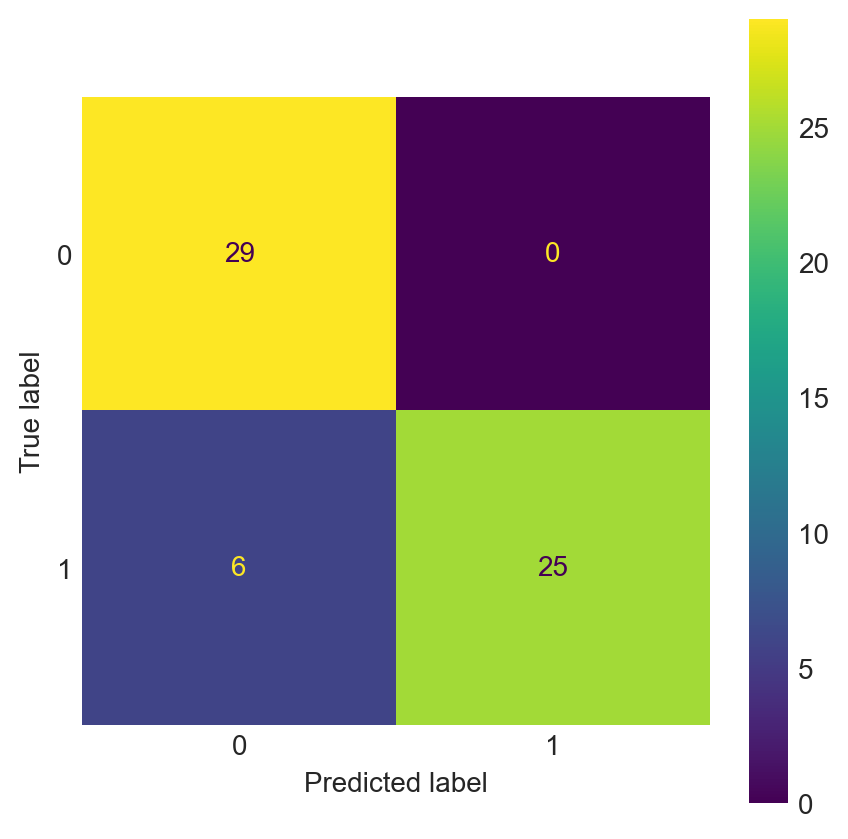

In [28]:
plt.style.use('_mpl-gallery-nogrid')

fig, ax = plt.subplots(figsize=(4, 4), dpi=200)

ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, ax=ax)

plt.show()

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        29
           1       1.00      0.81      0.89        31

    accuracy                           0.90        60
   macro avg       0.91      0.90      0.90        60
weighted avg       0.92      0.90      0.90        60



## Tuning Logistic Regression <a id='tuning-log-reg'></a>
[Back to top](#top)

In [30]:
grid_log_reg = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-100, 100, 7),
    'solver': ['liblinear']
}

log_reg = LogisticRegression()

gs_log_reg = GridSearchCV(log_reg,
                          param_grid=grid_log_reg,
                          verbose=2)

gs_log_reg.fit(X_train, y_train)


Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] END .............C=1e-100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .............C=1e-100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .............C=1e-100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .............C=1e-100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .............C=1e-100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .............C=1e-100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .............C=1e-100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .............C=1e-100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .............C=1e-100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .............C=1e-100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=2.154434690031931e-67, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=2.154434690031931e-67, penalty=l1, 

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-100, 2.15443469e-067, 4.64158883e-034, 1.00000000e+000,
       2.15443469e+033, 4.64158883e+066, 1.00000000e+100]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=2)

In [31]:
gs_log_reg.best_estimator_

LogisticRegression(penalty='l1', solver='liblinear')

In [32]:
gs_log_reg.best_score_

0.8143617021276596

In [33]:
log_reg = LogisticRegression(penalty='l1', solver='liblinear')
log_reg.fit(X_train, y_train)

y_pred_log_reg = log_reg.predict(X_test)

print(accuracy_score(y_test, y_pred_log_reg))


0.8666666666666667


In [34]:
log_reg.score(X_test, y_test)

0.8666666666666667

In [35]:
print(classification_report(y_test, y_pred_log_reg))


              precision    recall  f1-score   support

           0       0.82      0.93      0.87        29
           1       0.93      0.81      0.86        31

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60



## Tuning Random Forest Classifier <a id='tuning-rfclassifier'></a>
[Back to top](#top)

In [36]:
grid_rfc = {'n_estimators': [10, 20, 50, 100, 200, 500, 1000],
            'max_features': ['sqrt', 'log2']}

rd_cls = RandomForestClassifier()

gs_rfc = GridSearchCV(rd_cls,
                      param_grid=grid_rfc,
                      cv=10,
                      verbose=2)

gs_rfc.fit(X_train, y_train)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
[CV] END .................max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END .................max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END .................max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END .................max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END .................max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END .................max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END .................max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END .................max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END .................max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END .................max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END .................max_features=sqrt, n_estimators=20; total time=   0.0s
[CV] END .................max_features=sqrt, n

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 20, 50, 100, 200, 500, 1000]},
             verbose=2)

In [37]:
gs_rfc.best_estimator_

RandomForestClassifier(max_features='log2', n_estimators=20)

In [38]:
gs_rfc.best_score_

0.8231884057971015

In [39]:
rf_cls = RandomForestClassifier(n_estimators=20, max_features='log2')
rf_cls.fit(X_train, y_train)

y_pred_rf_cls = rf_cls.predict(X_test)

print(accuracy_score(y_test, y_pred_rf_cls))


0.7833333333333333


In [40]:
print(classification_report(y_test, y_pred_rf_cls))

              precision    recall  f1-score   support

           0       0.75      0.83      0.79        29
           1       0.82      0.74      0.78        31

    accuracy                           0.78        60
   macro avg       0.79      0.78      0.78        60
weighted avg       0.79      0.78      0.78        60



The KNN achieves higher score overall. I'm going to rebuild the KNN with `n_neighbors=13`. Train the model on the whole dataset and save it.

In [41]:
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

one_hot = OneHotEncoder(handle_unknown='ignore')

column_transformer = ColumnTransformer([('one_hot', one_hot, categorical_columns)])
X = column_transformer.fit_transform(X)

scaler = StandardScaler()
X = scaler.fit_transform(X)

knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X, y)


KNeighborsClassifier(n_neighbors=13)

## Save the model <a id='save-model'></a>
[Back to top](#top)

**Note:** Un-comment the code below to save/overwrite the model

In [42]:
# save the knn model
# joblib.dump(knn, './final_model.joblib')

# save the ColumnTransformer
# joblib.dump(column_transformer, './column_transformer.joblib')

# save the StandardScaler
# joblib.dump(scaler, './scaler.joblib')

['./scaler.joblib']

## Predict a single patient <a id='predict-single'></a>
[Back to top](#top)

In [43]:
loaded_ct = joblib.load('./column_transformer.joblib')
loaded_scaler = joblib.load('./scaler.joblib')
loaded_model = joblib.load('./final_model.joblib')


In [44]:
df_heart_disease.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [45]:
a_patient = {
    'age': 55,
    'sex': 1,
    'cp': 2,
    'trestbps': 140,
    'chol': 261,
    'fbs': 1,
    'restecg': 1,
    'thalach': 131,
    'exang': 0,
    'oldpeak': 1.7,
    'slope': 0,
    'ca': 2,
    'thal': 1,
}

a_patient = pd.DataFrame(a_patient, index=[0])

a_patient = loaded_ct.transform(a_patient)
a_patient = loaded_scaler.transform(a_patient)
loaded_model.predict(a_patient)

array([1], dtype=int64)